# Sprawozdanie z MIO laboratorium 06 - Marcin Knapczyk




In [ ]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 17.0 MB/s eta 0:00:00


# Zadanie 1

Proszę zaprojektować rozmyty system sterowania automatycznym podlewaniem grządki. Grządka ma 3m^2, a system podlewania może nawadniać w tempie maksymalnie 25l/dziennie, podczas, gdy zalecana ilość wody dla "zwyczajnych" warunków dla grządki w takim rozmiarze to 10l/dziennie.

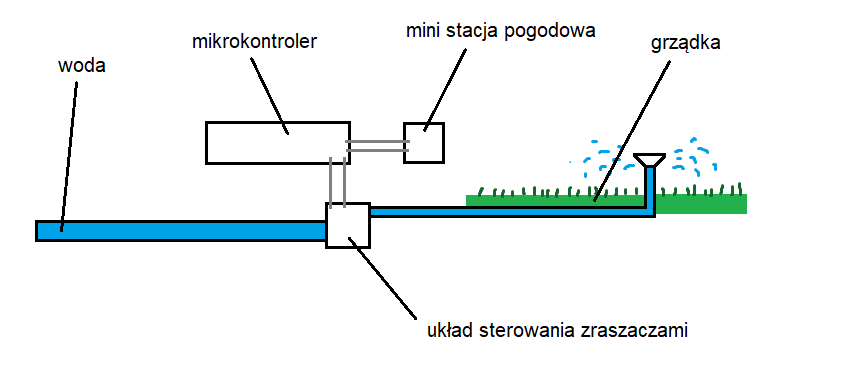

System jest sterowany elektronicznie i jest do niego podłączony higrometr (mierzący wilgotność względną w zakresie od 0% do 100%) i termometr. Temperatury są mierzone wyłącznie za dnia i znajdują się w zakresie 15°C - 35°C.Proszę zaprojektować układ rozmytego sterowania, układając reguły na podstawie następującej tabelki:

|                 | Sucho             | Przeciętnie                | Mokro      |
|-----------------|----------------------|----------------------|------------------|
| **Chłodno**     | Podlewaj średnio        | Podlewaj średnio     | Podlewaj mało    |
| **Ciepło**      | Podlewaj dużo        | Podlewaj średnio        | Podlewaj mało |
| **Gorąco**      | Podlewaj dużo | Podlewaj dużo        | Podlewaj średnio    |

Proszę samodzielnie zaproponować rozmyte funkcje przynależności i narysować je na wykresach. Proszę przedstawić heatmapę wynikowej funkcji ilości wody używanej dziennie w zależności od wilgotności i temperatury ukrytej w mechanizmie sterowania.

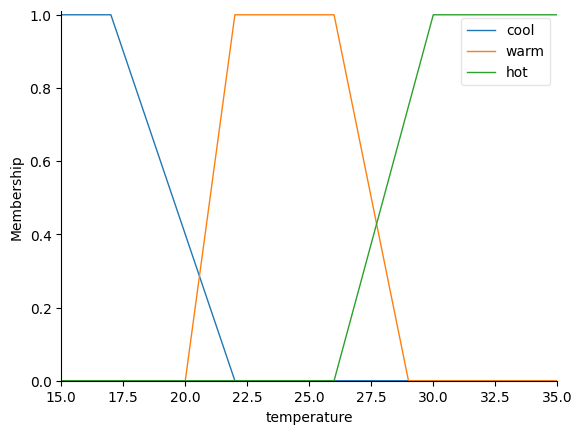

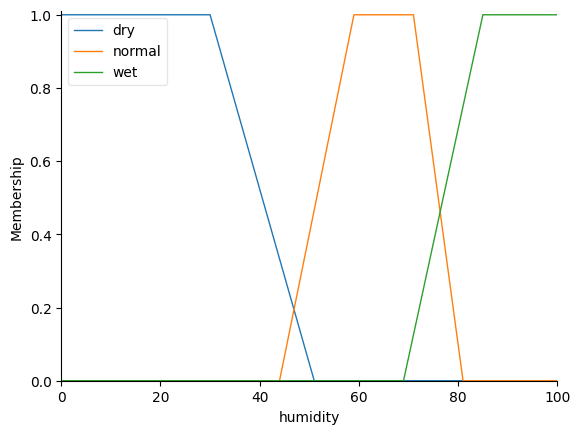

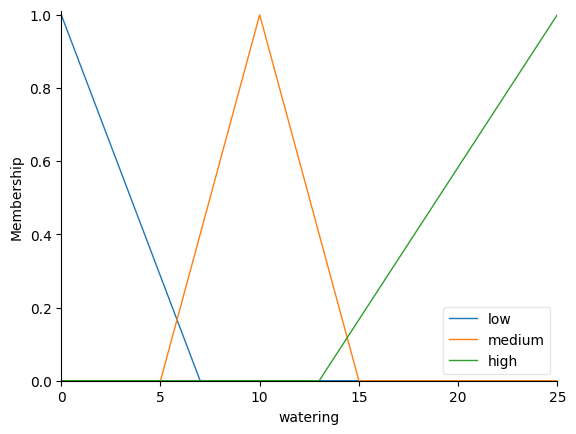

In [ ]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from skfuzzy import control as ctrl


temperature = ctrl.Antecedent(np.arange(15, 36, 1), "temperature")
humidity = ctrl.Antecedent(np.arange(0, 101, 1), "humidity")

watering = ctrl.Consequent(np.arange(0, 26, 1), "watering")

# temperatura
temperature["cool"] = fuzz.trapmf(temperature.universe, [15, 15, 17, 22])
temperature["warm"] = fuzz.trapmf(temperature.universe, [20, 22, 26, 29])
temperature["hot"] = fuzz.trapmf(temperature.universe, [26, 30, 35, 35])

# wilgotność
humidity["dry"] = fuzz.trapmf(humidity.universe, [0, 0, 30, 51])
humidity["normal"] = fuzz.trapmf(humidity.universe, [44, 59, 71, 81])
humidity["wet"] = fuzz.trapmf(humidity.universe, [69, 85, 100, 100])

# ilość wody
watering["low"] = fuzz.trimf(watering.universe, [0, 0, 7])
watering["medium"] = fuzz.trimf(watering.universe, [5, 10, 15])  # środek skoncentrowany na 10L (warunki "zwyczajne")
watering["high"] = fuzz.trimf(watering.universe, [13, 25, 25])

temperature.view()
humidity.view()
watering.view()


Temp. 30 st. C, wilgotność 25% 
Zalecana ilość wody: 21.0 litrów
Temp. 17 st. C, wilgotność 85% 
Zalecana ilość wody: 2.33 litrów
Temp. 22 st. C, wilgotność 68% 
Zalecana ilość wody: 10.0 litrów


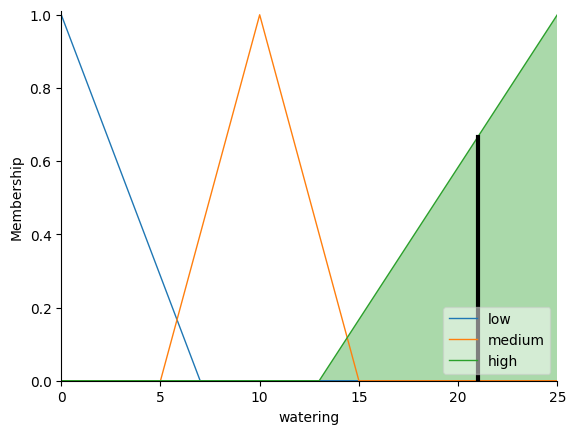

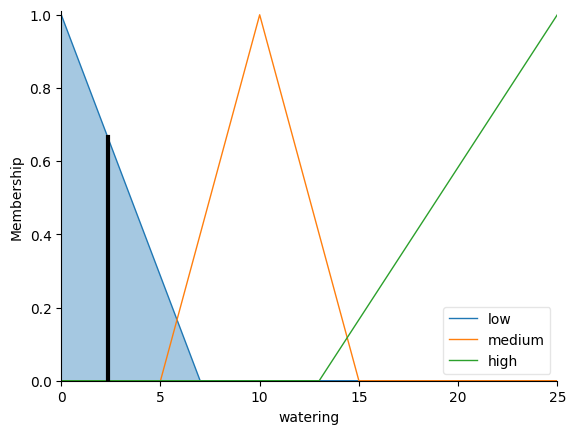

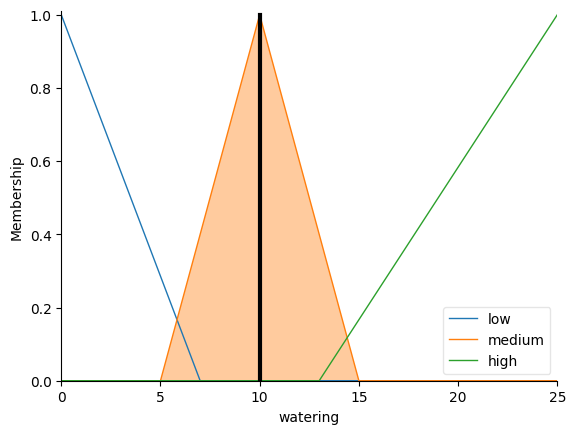

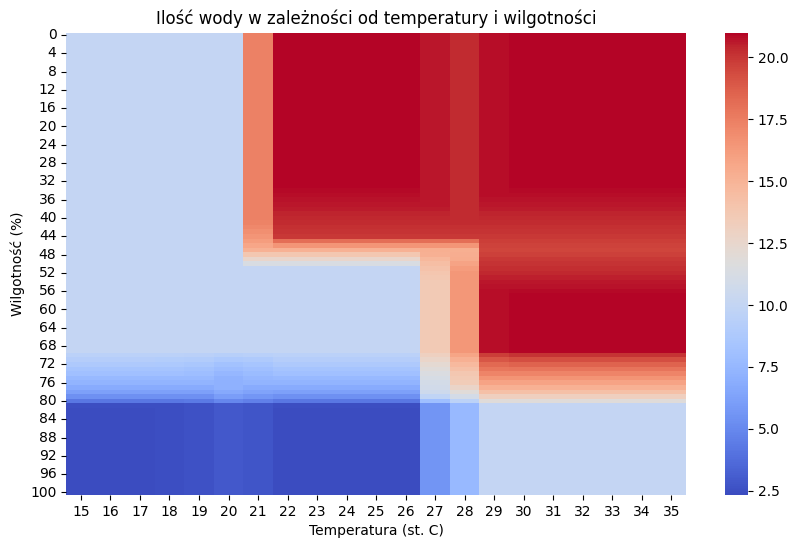

In [ ]:
# reguły
rules = [
    ctrl.Rule(temperature["cool"] & humidity["dry"], watering["medium"]),
    ctrl.Rule(temperature["cool"] & humidity["normal"], watering["medium"]),
    ctrl.Rule(temperature["cool"] & humidity["wet"], watering["low"]),

    ctrl.Rule(temperature["warm"] & humidity["dry"], watering["high"]),
    ctrl.Rule(temperature["warm"] & humidity["normal"], watering["medium"]),
    ctrl.Rule(temperature["warm"] & humidity["wet"], watering["low"]),

    ctrl.Rule(temperature["hot"] & humidity["dry"], watering["high"]),
    ctrl.Rule(temperature["hot"] & humidity["normal"], watering["high"]),
    ctrl.Rule(temperature["hot"] & humidity["wet"], watering["medium"]),
]

watering_ctrl = ctrl.ControlSystem(rules)
watering_sim = ctrl.ControlSystemSimulation(watering_ctrl)

# przykładowe dane wejściowe
watering_sim.input["temperature"] = 30  # dosyć wysoka temperatura
watering_sim.input["humidity"] = 25  # bardzo niska wilgotność
watering_sim.compute()
print(f"Temp. 30 st. C, wilgotność 25% \nZalecana ilość wody: {round(watering_sim.output['watering'], 2)} litrów")
watering.view(sim=watering_sim)

watering_sim.input["temperature"] = 17  # dosyć niska temperatura
watering_sim.input["humidity"] = 85   # wysoka wilgotność
watering_sim.compute()
print(f"Temp. 17 st. C, wilgotność 85% \nZalecana ilość wody: {round(watering_sim.output['watering'], 2)} litrów")
watering.view(sim=watering_sim)

watering_sim.input["temperature"] = 22  # temperatura w normie
watering_sim.input["humidity"] = 68  # normalna wilgotność
watering_sim.compute()
print(f"Temp. 22 st. C, wilgotność 68% \nZalecana ilość wody: {round(watering_sim.output['watering'], 2)} litrów")
watering.view(sim=watering_sim)

# heatmapa
temp_grid, humi_grid = np.meshgrid(np.arange(15, 36, 1), np.arange(0, 101, 1))
output_vals = []

for h, t in zip(np.ravel(humi_grid), np.ravel(temp_grid)):
    watering_sim.input["temperature"] = t
    watering_sim.input["humidity"] = h
    try:
        watering_sim.compute()
        output_vals.append(watering_sim.output["watering"])
    except:
        output_vals.append(np.nan)

heatmap_data = pd.DataFrame({
    "Temperature": np.ravel(temp_grid),
    "Humidity": np.ravel(humi_grid),
    "Watering": output_vals
})

heatmap_pivot = heatmap_data.pivot(index="Humidity", columns="Temperature", values="Watering")

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_pivot, cmap="coolwarm")
plt.title("Ilość wody w zależności od temperatury i wilgotności")
plt.xlabel("Temperatura (st. C)")
plt.ylabel("Wilgotność (%)")
plt.show()


## Wnioski:
* System determinuje ilość potrzebnej do podlania grządki wody na podstawie odczytów pomiaru temperatury i wilgoci
* Parametry temperatury i wilgoci dostosowane zostały do warunków polskich
* Parametr temperatury obsługuje wartości z zakresu 15-35 st. C i ma ustawioną trapezową funkcję przynależności, co daje płynniejsze przejścia zimno-ciepło-gorąco i większą tolerancję, gdyż system bierze pod uwagę niepewności pomiarowe
* Parametr wilgotności (%) przyjmuje wartości 0-100%, gdzie za normę wzięte jest 60-70%. Funkcja przynależniości została dobrana z tych samych powodów, co w przypadku parametry temperatury
* Dla ilości wody dobrana została trójkątna funkcja przynależności, gdyż pozwala ona na dokładne określenie ilości wody dla "zwyczajnych" warunków, czyli 10L. Wartości są z zakresu 0-25L
* Analizując testowe wyniki widać, że system odpowiednio dobrał ilość wody do zadanych warunków
* W przypadku wysokiej temperatury i niskiej wilgotności system proponuje zwiększoną ilość wody
* Dla niskiej temperatury i wysokiej wilgotności system sugeruje małą ilość wody
* Dla warunków "zwyczajnych" system doradza 10L
* Analizując heatmapę wiudzimy, że użycie trapezowych funkcji przynależności poskutkowało łagodniejszymi przejściami między strefami
* Widać, że przy wysokiej wilgotności podlewanie jest ograniczone (dochodzi do 10L tylko dla wysokich temperatur)
* Dla niskiej wilgotności ilośc potrzebnej wody szybko rośnie wraz z temperaturą i nawet dla standardowej temperatury 21-22 st. C ilość potrzebnej wody skacze do maksymalnej ilości 25L

# Zadanie 2

Proszę zaproponować rozmyty system wnioskowania dla dowolnego wybranego (ale różnego od poruszanych dotychczas) problemu. Proszę wziąć pod uwagę co najmniej trzy zmienne wejściowe i każdą zmienną podzielić na co najmniej trzy zbiory rozmyte. Proszę stworzyć co najmniej 5 reguł i skomentować wyniki.

Im rzadziej Państwa pomysły będą się powtarzać, tym lepiej.

## System służy do oceny jakości snu w skali 0-10 (np. aplikacja na smartwatcha) na podstawie: ilości przebudzeń, tętna i długości snu

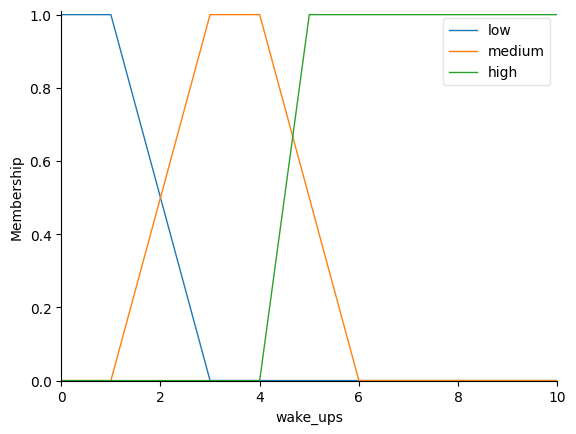

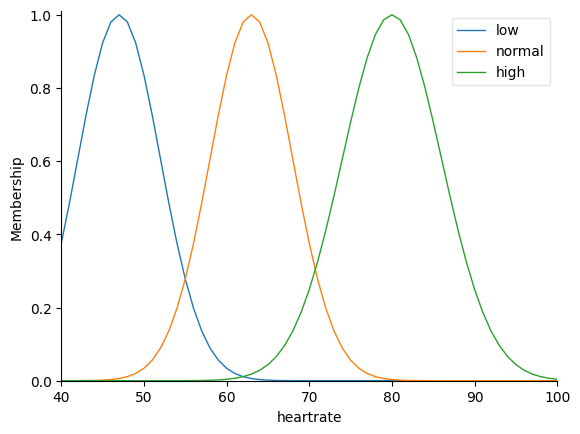

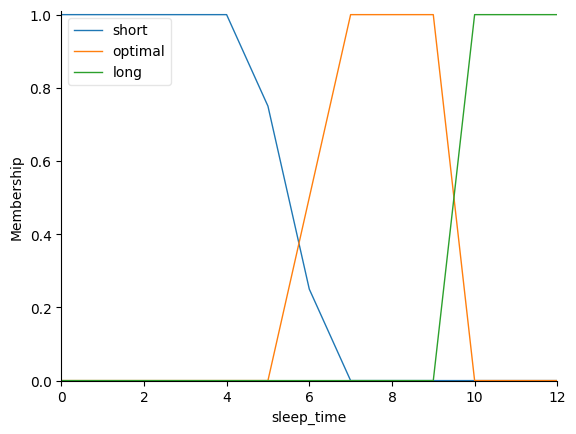

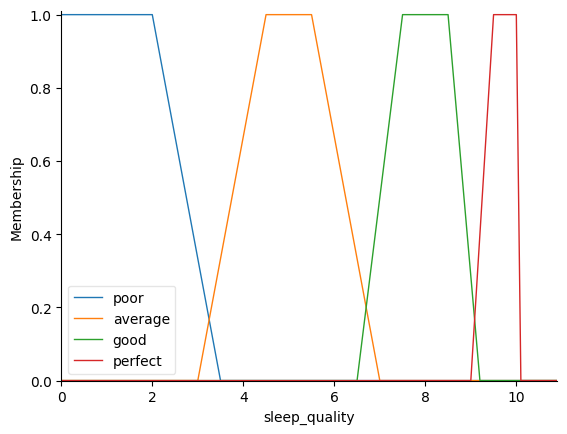

In [ ]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from skfuzzy import control as ctrl


wake_ups = ctrl.Antecedent(np.arange(0, 11, 1), "wake_ups")
heartrate = ctrl.Antecedent(np.arange(40, 101, 1), "heartrate")
sleep_time = ctrl.Antecedent(np.arange(0, 13, 1), "sleep_time")

sleep_quality = ctrl.Consequent(np.arange(0, 11, 0.1), "sleep_quality")

# funkcje przynależności
# ilość przebudzeń
wake_ups["low"] = fuzz.trapmf(wake_ups.universe, [0, 0, 1, 3])
wake_ups["medium"] = fuzz.trapmf(wake_ups.universe, [1, 3, 4, 6])
wake_ups["high"] = fuzz.trapmf(wake_ups.universe, [4, 5, 10, 10])

# tętno (BPM)
heartrate["low"] = fuzz.gaussmf(heartrate.universe, 47, 5)
heartrate["normal"] = fuzz.gaussmf(heartrate.universe, 63, 5)
heartrate["high"] = fuzz.gaussmf(heartrate.universe, 80, 6)

# czas snu w godzinach
sleep_time["short"] = fuzz.trapmf(sleep_time.universe, [0, 0, 4.5, 6.5])
sleep_time["optimal"] = fuzz.trapmf(sleep_time.universe, [5, 7, 9.5, 10])
sleep_time["long"] = fuzz.trapmf(sleep_time.universe, [9, 10, 12, 12])

# jakość snu 0-10
sleep_quality["poor"] = fuzz.trapmf(sleep_quality.universe, [0, 0, 2, 3.5])
sleep_quality["average"] = fuzz.trapmf(sleep_quality.universe, [3, 4.5, 5.5, 7])
sleep_quality["good"] = fuzz.trapmf(sleep_quality.universe, [6.5, 7.5, 8.5, 9.2])
sleep_quality["perfect"] = fuzz.trapmf(sleep_quality.universe, [9, 9.5, 10, 10])


wake_ups.view()
heartrate.view()
sleep_time.view()
sleep_quality.view()

# reguły
rules = [
    ctrl.Rule(wake_ups["low"] & heartrate["low"] & sleep_time["optimal"], sleep_quality["perfect"]),
    ctrl.Rule(wake_ups["low"] & heartrate["normal"] & sleep_time["optimal"], sleep_quality["good"]),
    ctrl.Rule(wake_ups["low"] & heartrate["low"] & sleep_time["long"], sleep_quality["perfect"]),
    ctrl.Rule(wake_ups["low"] & heartrate["normal"] & sleep_time["long"], sleep_quality["good"]),
    ctrl.Rule(wake_ups["low"] & heartrate["low"] & sleep_time["short"], sleep_quality["average"]),

    ctrl.Rule(wake_ups["medium"] & heartrate["normal"] & sleep_time["optimal"], sleep_quality["average"]),
    ctrl.Rule(wake_ups["medium"] & heartrate["low"] & sleep_time["optimal"], sleep_quality["average"]),
    ctrl.Rule(wake_ups["medium"] & heartrate["normal"] & sleep_time["long"], sleep_quality["average"]),

    ctrl.Rule(wake_ups["medium"] & heartrate["high"], sleep_quality["poor"]),
    ctrl.Rule(heartrate["low"] & sleep_time["short"], sleep_quality["poor"]),
    ctrl.Rule(wake_ups["low"] & sleep_time["short"], sleep_quality["poor"]),
    ctrl.Rule(wake_ups["low"] & heartrate["normal"] & sleep_time["short"], sleep_quality["poor"]),
    ctrl.Rule(sleep_time["long"] & heartrate["high"], sleep_quality["average"]),
    ctrl.Rule(sleep_time["short"] | wake_ups["high"] | heartrate["high"], sleep_quality["poor"]),
]

quality_ctrl = ctrl.ControlSystem(rules)
quality_sim = ctrl.ControlSystemSimulation(quality_ctrl)


Wejście: {'wake_ups': 1, 'heartrate': 55, 'sleep_time': 8} -> Jakość snu: 8.35
Wejście: {'wake_ups': 0, 'heartrate': 50, 'sleep_time': 8.5} -> Jakość snu: 9.43
Wejście: {'wake_ups': 4, 'heartrate': 70, 'sleep_time': 6} -> Jakość snu: 3.7
Wejście: {'wake_ups': 8, 'heartrate': 90, 'sleep_time': 9} -> Jakość snu: 1.41


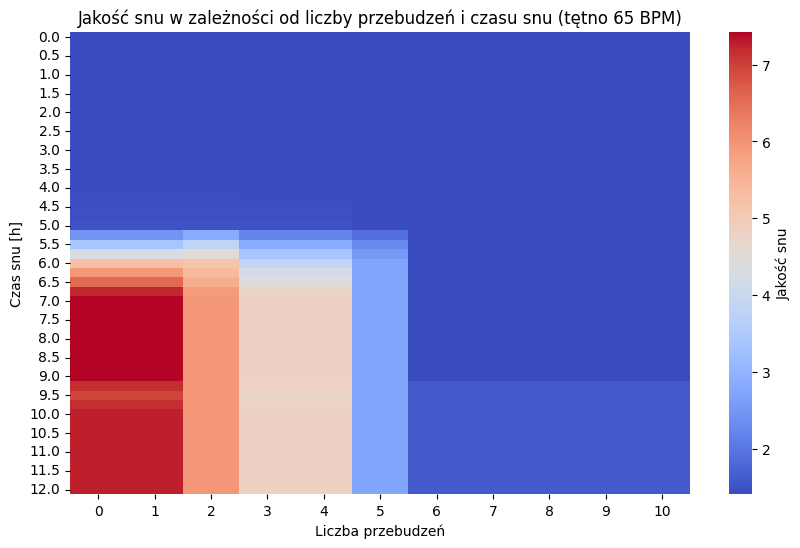

In [ ]:
# testowe dane
samples = [
    {"wake_ups": 1, "heartrate": 55, "sleep_time": 8},
    {"wake_ups": 0, "heartrate": 50, "sleep_time": 8.5},
    {"wake_ups": 4, "heartrate": 70, "sleep_time": 6},
    {"wake_ups": 8, "heartrate": 90, "sleep_time": 9},
]

for s in samples:
    quality_sim.input["wake_ups"] = s["wake_ups"]
    quality_sim.input["heartrate"] = s["heartrate"]
    quality_sim.input["sleep_time"] = s["sleep_time"]
    quality_sim.compute()
    print(f"Wejście: {s} -> Jakość snu: {round(quality_sim.output['sleep_quality'], 2)}")

# heatmapa (dla HR = 65 bpm)
w_grid, s_grid = np.meshgrid(np.arange(0, 11, 1), np.arange(0, 12.25, 0.25))
output_vals = []

for w, s in zip(np.ravel(w_grid), np.ravel(s_grid)):
    quality_sim.input["wake_ups"] = w
    quality_sim.input["heartrate"] = 65
    quality_sim.input["sleep_time"] = s
    try:
        quality_sim.compute()
        output_vals.append(quality_sim.output["sleep_quality"])
    except:
        output_vals.append(np.nan)

heatmap_data = pd.DataFrame({
    "Wake-ups": np.ravel(w_grid),
    "SleepTime": np.ravel(s_grid),
    "SleepQuality": output_vals
})
heatmap_pivot = heatmap_data.pivot(index="SleepTime", columns="Wake-ups", values="SleepQuality")

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_pivot, cmap="coolwarm", cbar_kws={"label": "Jakość snu"})
plt.title("Jakość snu w zależności od liczby przebudzeń i czasu snu (tętno 65 BPM)")
plt.xlabel("Liczba przebudzeń")
plt.ylabel("Czas snu [h]")
plt.show()

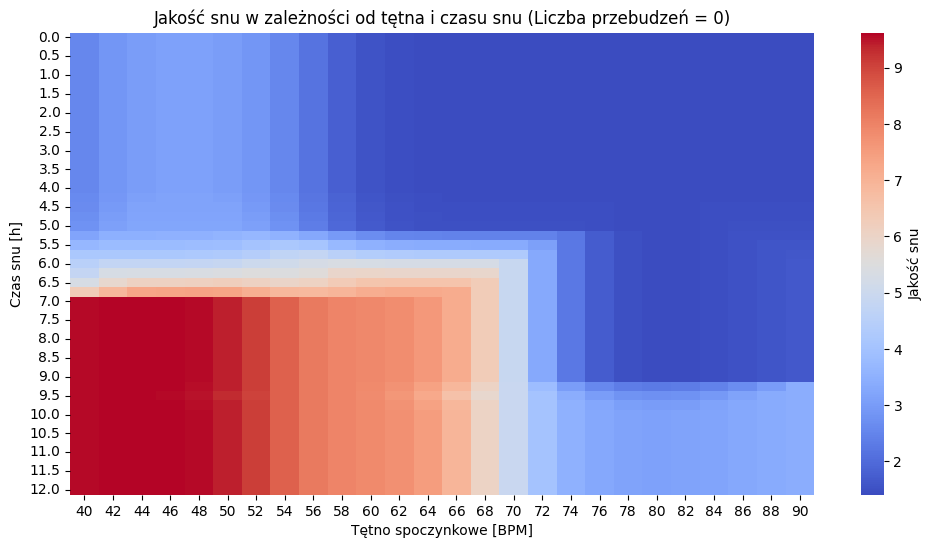

In [ ]:
# heatmapa (dla ilości przebudzeń = 0)
hr_grid, st_grid = np.meshgrid(np.arange(40, 91, 2), np.arange(0, 12.25, 0.25))
output_vals = []

for hr, st in zip(np.ravel(hr_grid), np.ravel(st_grid)):
    quality_sim.input["wake_ups"] = 0
    quality_sim.input["heartrate"] = hr
    quality_sim.input["sleep_time"] = st
    try:
        quality_sim.compute()
        output_vals.append(quality_sim.output["sleep_quality"])
    except:
        output_vals.append(np.nan)

heatmap_data = pd.DataFrame({
    "HeartRate": np.ravel(hr_grid),
    "SleepTime": np.ravel(st_grid),
    "SleepQuality": output_vals
})
heatmap_pivot = heatmap_data.pivot(index="SleepTime", columns="HeartRate", values="SleepQuality")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_pivot, cmap="coolwarm", cbar_kws={"label": "Jakość snu"})
plt.title("Jakość snu w zależności od tętna i czasu snu (Liczba przebudzeń = 0)")
plt.xlabel("Tętno spoczynkowe [BPM]")
plt.ylabel("Czas snu [h]")
plt.show()


## Wnioski:
* System oceny jakości snu działa w oparciu o trzy parametry: liczbę przebudzeń, tętno spoczynkowe oraz długość snu. Ich zakresy i funkcje przynależności zostały dobrane tak, by odzwierciedlać typowe wartości spotykane u dorosłych osób, zgodnie z danymi medycznymi
* Parametr wake_ups (liczba przebudzeń w nocy) przyjmuje wartości z zakresu 0–10 i został rozmyty za pomocą trapezowych funkcji przynależności. Przedziały:
  * low obejmuje sytuacje optymalne (0-3 przebudzenia)
  * medium (2-6) wpływa negatywnie na jakość snu
  * high (od 4 do 10) determinuje niską jakość snu
* Parametr heartrate (tętno spoczynkowe) używa funkcji gussowskiej w celu poprawnego opisu cech biologicznych. Przyjmuje wartości z zakresu 40-100 BPM, gdzie:
  * low (środek w okolicach 47) odpowiada właściwemu snu,
  * normal (centrum ok. 63 BPM) to przeciętna wartość snu wynikająca z danych medycznych,
  * high (>75 BPM) sugeruje napięcie lub stres
* Sleep_time modeluje długość snu w przedziale 0 do 12h:
   * short sen poniżej 6.5 h,
   * optimal obejmuje zalecane 7-9 h,
   * long to wartości powyżej 9 h
* sleep_quality (0-10) jest podzielone na cztery kategorie: poor, average, good i perfect. Użyte zostały trapezowe funkcje przynależności, by umożliwić płynne przejścia jakości snu

* Analizując wyniki widać, że system poprawnie ocenia wysoką jakość snu tylko w warunkach niskiego tętna, długiego snu i małej liczby przebudzeń
* Przy wysokim tętnie lub zbyt dużej liczbie przebudzeń, nawet długi sen nie skutkuje wysoką oceną (przypadek z HR=90, 9h, 8 przebudzeń)
* Krótki sen (6h) i średnie parametry tętna/przebudzeń skutkują tylko przeciętną jakością snu, a dla jeszczwe krótszego czasu jakość snu przyjmuje niskie wartości (nie wystarczająco dużo czasu na możliwość regeneracji)
* Nawet średnia ilośc przebudzeń (od 2) skutkuje znacznym spadkiem jakości snu, a dla wartości wysokich jakość snu jest bardzo niska bez względu na inne parametry

In [ ]:
!jupyter nbconvert --to html /content/MIO_lab06_report.ipynb

[NbConvertApp] Converting notebook /content/MIO_lab06_report.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 13 image(s).
[NbConvertApp] Writing 932592 bytes to /content/MIO_lab06_report.html
